![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
#matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from math import log
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Lectura de la información de archivo .csv
#data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')
data = pd.read_csv('../datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

#### Funciones

In [5]:
# Celda 1
#Definición de función para calcular el MAE
def MAE_calculation(y_test, y_pred):
    mae = np.mean(np.abs(y_test - y_pred))
    return mae

#Definición de función para calcular el RMSE
def MSE_calculation(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))
    
# Definición de la función best_split_reg para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol en problemas de regresión
def best_split_reg(X, y, num_pct):
    
    # Obtener los percentiles
    percentiles = np.percentile(X, np.arange(0, 100, num_pct)).tolist()
    
    # Agregar los extremos
    percentiles = [-np.inf] + percentiles + [np.inf]
    
    # Inicializar los valores
    best_j, best_split, best_gain = None, None, np.inf
    
    # Recorrer todas las combinaciones de j y split
    for j in range(X.shape[1]):
        for split in percentiles:
            y_l, y_r = y[X.iloc[:, j] < split], y[X.iloc[:, j] >= split]
            if y_l.shape[0] > 0 and y_r.shape[0] > 0:
                y_mean_l, y_mean_r = y_l.mean(), y_r.mean()
                gain = ((y_l - y_mean_l)**2).sum() + ((y_r - y_mean_r)**2).sum()
                if gain < best_gain:
                    best_j, best_split, best_gain = j, split, gain
    
    return best_j, best_split, best_gain


#Definición de función para calibrar la profundidad del árbol
def calibrate_max_depth(num_folds, max_depth_values, X, y):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    result = []
    for max_depth in max_depth_values:
        mse_fold = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            tree = tree_grow(X_train, y_train, max_depth=max_depth)
            y_pred = tree_predict(X_val, tree)
            mse_fold.append(np.mean((y_val - y_pred)**2))
        result.append([max_depth, np.mean(mse_fold)])
    result = np.array(result)
    optimal_max_depth = result[np.argmin(result[:,1]),0]
    return optimal_max_depth


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_std=0, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split_reg(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean() 
    y_std = y.std()
    
    tree = dict(y_pred=y_pred, y_std=y_std, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])
    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
    return predicted

#### Ejecución del modelo

In [6]:
num_folds = 10
max_depth_values = range(1,5)
best_max_depth = calibrate_max_depth(num_folds, max_depth_values, X_train, y_train)
tree = tree_grow(X_train, y_train, max_depth=best_max_depth)
y_pred = tree_predict(X_test, tree)
RMSE = MSE_calculation(y_test, y_pred)**0.5
MAE = MAE_calculation(y_test, y_pred)
print('RMSE: ', RMSE)
print('MAE: ', MAE)

RMSE:  2108.2214431762013
MAE:  1610.1665629744748


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [7]:
# Celda 2
# Creación de 10 muestras de bootstrap
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

# Construcción un árbol de decisión para cada muestra boostrap
# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_trainb = X_train.iloc[sample, :]
    y_trainb = y_train.iloc[sample]
    treereg.fit(X_trainb, y_trainb)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred=y_pred.mean(axis=1)

rmse=np.sqrt(mean_squared_error(y_pred, y_test))

print("RMSE", rmse)

mae = mean_absolute_error(y_test, y_pred)

print("MAE:", mae)

RMSE 1796.4355868399332
MAE: 1340.0160739030025


Con un RMSE de 1796.43 y un MAE de 1340.016, podemos decir que el modelo bagging de 10 árboles de regresión tiene un desempeño aceptable para predecir el precio de los automóviles. El MAE indica que el modelo, en promedio, se desvía en 1340.016 unidades del precio real, mientras que el RMSE indica que la dispersión de los errores de predicción es de 1796.43 unidades en promedio.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [8]:
# Celda 3

max_features = int(log(X_train.shape[1]))
tree_reg = DecisionTreeRegressor()
bag_reg = BaggingRegressor(base_estimator=tree_reg, n_estimators=10, max_features=max_features)
bag_reg.fit(X_train, y_train)
y_pred = bag_reg.predict(X_test)


rmse=np.sqrt(mean_squared_error(y_pred, y_test))

print("RMSE", rmse)
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

RMSE 2526.318122407954
MAE: 1949.164880551567


Comparando los resultados del segundo modelo con los del primer modelo, podemos observar que el RMSE y el MAE del segundo modelo son mayores que los del primer modelo. Esto puede indicar que el segundo modelo tiene un desempeño inferior para predecir el precio de los automóviles.

El hecho de que el segundo modelo haya utilizado el logaritmo del número total de features como valor para el parámetro max_features puede indicar que se intentó reducir la complejidad del modelo al limitar el número de features considerados en cada árbol de regresión. Sin embargo, es importante señalar que la selección del valor adecuado para este parámetro puede ser un proceso complejo y debe basarse en la exploración de diferentes opciones y técnicas de validación.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [9]:
# Celda 4
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)


rmse=np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE", rmse)
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

RMSE 1758.1086780656174
MAE: 1309.794721197602


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

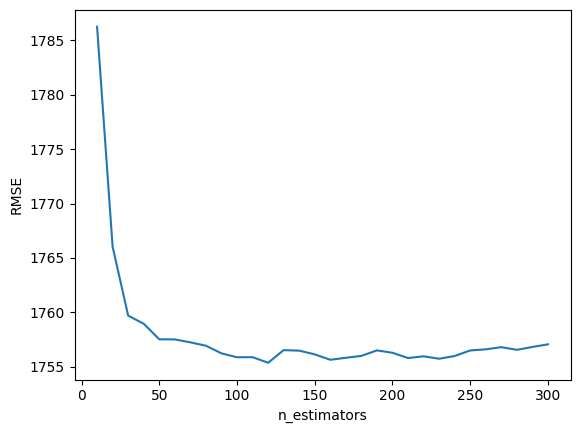

El menor RMSE se alcanza con: 120 estimadores y es igual a 1755.3655840329534


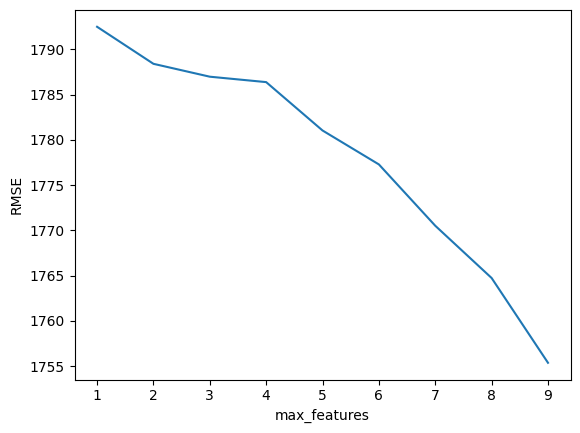

El menor RMSE se alcanza con: 9 features y es igual a 1755.3655840329534


In [10]:
# Celda 5
import matplotlib.pyplot as plt
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
rmse_scores = []

# Calibración de n_estimators
for estimator in estimator_range:
    rf_reg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_pred, y_test)))

plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()

min_index = np.argmin(rmse_scores)
min_index
rmse_scores[min_index]
estimator_range[min_index]
print("El menor RMSE se alcanza con:", estimator_range[min_index], "estimadores y es igual a", rmse_scores[min_index])


# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X_train.shape[1]+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
rmse_scores = []

# Calibración de max_features
for feature in feature_range:
    rf_reg = RandomForestRegressor(n_estimators=estimator_range[min_index], max_features=feature, random_state=1, n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
plt.plot(feature_range, rmse_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.show()

min_index = np.argmin(rmse_scores)
min_index
rmse_scores[min_index]
estimator_range[min_index]
print("El menor RMSE se alcanza con:", feature_range[min_index], "features y es igual a", rmse_scores[min_index])


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
